<center><h1><b><span style="color:blue">Playing with the HEP system of units</span></b></h1></center>

**Or, an intro to the `hepunits` package while performing some time-of-flight studies**.

Scikit-HEP packages used:
- [`hepunits`](https://github.com/scikit-hep/hepunits)
- [`Particle`](https://github.com/scikit-hep/particle)

Author:
[Eduardo Rodrigues](https://github.com/eduardo-rodrigues/)

<center><h2><b><span style="color:green">hepunits - The HEP system of units</span></b></h2></center>

The package ``hepunits`` collects the most commonly used units and constants in the
HEP System of Units, which differs from the international system of units (aka SI units) by scaling factors
for what are the basic units.
The HEP system of units is based on the following:

| Quantity            | Name               | Unit|
| ------------------ :| ----------------- :| -- :|
|  Length             |  millimeter        | mm  |
|  Time               |  nanosecond        | ns  |
|  Energy             |  Mega electron Volt| MeV |
|  Positron charge    |  eplus             |     |
|  Temperature        |  kelvin            | K   |
|  Amount of substance|  mole              | mol |
|  Luminous intensity |  candela           | cd  |
| Plane angle         |  radian            | rad |
|  Solid angle        |  steradian         | sr  |

Note: no need to make use of sophisticated packages (e.g. as in AstroPy) since we basically never need to change systems of units (we never use ergs as energy, for example ;-)).

### **Basic usage**

**Basic usage is straightforward**, though it may be confusing at first.
Remember, all variables are written wrt to the units:

In [1]:
from hepunits import mm, ns, MeV, eplus, GeV, kelvin, mol, cd, rad, sr

mm == ns == MeV == eplus == kelvin == mol == cd == rad == sr == 1

True

In [2]:
GeV == 1000*MeV

True

<div class="alert alert-warning">

<b>Note:</b>

1. No error checking is implemented, since units are not objects, rather simple numbers.
Expressions such as `1*ns + 1*mm` produce no error.
2. Units help improving the readability of code and making formula explicit (although correctness must be still manually checked).

</div>

Add two quantities with different length units:

In [3]:
from hepunits import units as u

1*u.meter + 5*u.cm

1050.0

The result is in HEP units, so mm. Indeed, for example `u.meter == 1000 == 1000 * u.mm`. 

Rather obtain the result in meters:

In [4]:
(1*u.meter + 5*u.cm) / u.meter

1.05

Do you need to play a bit more to get a proper feeling? This next (non-academic) exercise should help you ...

### **Quick time-of-flight study**

Let's try to play with units in a meaningful way, in a kind of exercise that physicists encounter. Imagine you are investigating time-of-flight (ToF) detectors for particle identification. The time it takes a particle of velocity $\beta = v/c= pc/E$ to travel a distance $L$ is given by

$$\mathrm{ToF} = \frac{L}{c \beta}$$

It results that the mass $m$ of the particle can be determined from

$$m = \frac{p}{c}\sqrt{\frac{c^2 \mathrm{ToF}^2}{L^2}-1}$$

provided the path length $L$ and the momentum $p$ can be measured, say, by a tracking system.

What are typical ToF differences say for (charged) kaons and pions?
It is practical to perform the calculation as

$$\Delta \mathrm{ToF} = \frac{L}{c}(\frac{1}{\beta_1} - \frac{1}{\beta_2})\,,$$

with $\frac{1}{\beta} = \sqrt{1+m^2c^2/p^2}$.

In [5]:
from hepunits import c_light, GeV, meter, ps, ns

import numpy as np

def ToF(m, p, L):
    """Time-of-Flight = particle path length L / (c * beta)"""
    one_over_beta = np.sqrt(1 + m*m/(p*p))  # no c factors here because m and p given without them, hence c's cancel out ;-)
    return (L * one_over_beta /c_light)

For convenience, get hold of data for the proton, $K^+$ and $\pi^+$ taken from the PDG using the [`Particle` package](https://github.com/scikit-hep/particle):

In [6]:
from particle.literals import proton, pi_plus, K_plus  # particle name literals

Calculate the difference in ToF between 10 GeV kaons and pions travelling over 10 meters:

In [7]:
delta = ( ToF(K_plus.mass, 10*GeV, 10*meter) - ToF(pi_plus.mass, 10*GeV, 10*meter) ) / ps
print("At 10 GeV, Delta-TOF(K-pi) over 10 meters = {:.4} ps".format(delta))

At 10 GeV, Delta-TOF(K-pi) over 10 meters = 37.37 ps


Let's get a bit fancier:
- Compare protons, kaons and pions.
- Look at the ToF difference versus momentum.

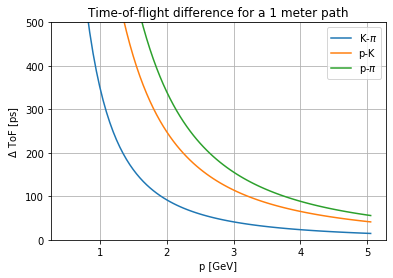

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

p = np.arange(0.5, 5.1, 0.05) * GeV

delta1 = ( ToF(K_plus.mass, p, 1.*meter) - ToF(pi_plus.mass, p, 1.*meter) ) / ps
delta2 = ( ToF(proton.mass, p, 1.*meter) - ToF(K_plus.mass, p, 1.*meter) ) / ps
delta3 = ( ToF(proton.mass, p, 1.*meter) - ToF(pi_plus.mass, p, 1.*meter) ) / ps

fig, ax = plt.subplots()
ax.plot(p/GeV, delta1, label='K-$\pi$')
ax.plot(p/GeV, delta2, label='p-K')
ax.plot(p/GeV, delta3, label='p-$\pi$')

ax.set(xlabel='p [GeV]', ylabel='$\Delta$ ToF [ps]',
       title='Time-of-flight difference for a 1 meter path')
ax.grid()

plt.legend()
plt.ylim(bottom=0, top=500)
plt.show()

Taking now an example that could be relevant to LHCb conditions - detector timing resolution requirement is getting tough!:

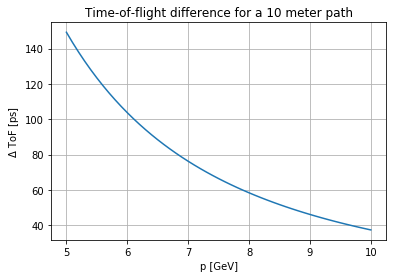

In [9]:
p = np.arange(5., 10.1, 0.1) * GeV
delta = ( ToF(K_plus.mass, p, 10*meter) - ToF(pi_plus.mass, p, 10*meter) ) / ps

fig, ax = plt.subplots()
ax.plot(p/GeV, delta)

ax.set(xlabel='p [GeV]', ylabel='$\Delta$ ToF [ps]',
       title='Time-of-flight difference for a 10 meter path')
ax.grid()

plt.show()

For short flight distances protons, kaons and pions become indistinguishable, as expected:

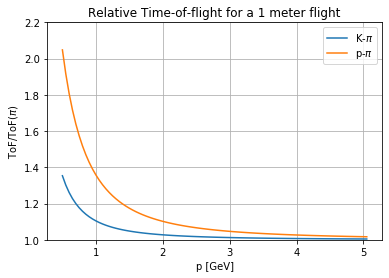

In [10]:
p = np.arange(0.5, 5.1, 0.05) * GeV
s1 = ( ToF(K_plus.mass, p, 1.38*meter) / ToF(pi_plus.mass, p, 1.38*meter) )
s3 = ( ToF(proton.mass, p, 1.38*meter) / ToF(pi_plus.mass, p, 1.38*meter) )

fig, ax = plt.subplots()
ax.plot(p/GeV, s1, label='K-$\pi$')
ax.plot(p/GeV, s3, label='p-$\pi$')

ax.set(xlabel='p [GeV]', ylabel='ToF/ToF($\pi$)',
       title='Relative Time-of-flight for a 1 meter flight')
ax.grid()

plt.ylim(bottom=1, top=2.2)
plt.legend()
plt.show()